I'm going to try writing a 'flat ACF' method as described in Huber+09, Viani+19, and references therein. Just to see if it works better than what I currently have built into lightkurve.

In [1]:
import sys
sys.path.append('/home/oliver/PhD/Hacks_and_Mocks/')
import lightkurve as lk
print(lk.__version__)
import numpy as np
from astropy.units import cds
from astropy import units as u
import pylab as plt

1.1.dev


Lets get the data as we usually would

In [2]:
datalist = lk.search_lightcurvefile('16CygA',cadence='short')
data = datalist[3:4].download_all()
lc = data[0].PDCSAP_FLUX.normalize().flatten()
for nlc in data:
    lc = lc.append(nlc.PDCSAP_FLUX.normalize().flatten())
lc = lc.remove_nans()
pg = lc.to_periodogram(normalization='psd')
snr = pg.flatten()

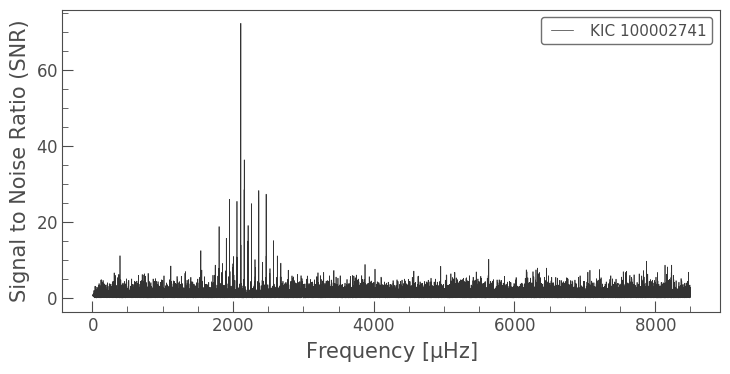

In [3]:
snr.plot()

Now lets construct the ACF, borrowing some code frome lk.periodogram

We calcualte the autocorrelation for a 25 $\mu$Hz wide window. The central frequency is moved forwards by 1 $\mu$Hz until we reach the end of the spectrum (presumeably, until the end of the spectrum is equal to the end of the window, so window width remains consistent).

This could be problematic for low-numax situations.

In [4]:
f = snr.frequency.value
p = snr.power.value
numaxs = np.arange(125, np.floor((f.max()))-125, 1.)

In [5]:
def autocorrelate(numax):
    fs = np.median(np.diff(f))
    spread = int(125/fs)
    x = int(numax / fs)                                 
    p_han = p[x-spread:x+spread]
    C = np.correlate(p_han, p_han, mode='full')         #Correlated the resulting SNR space with itself
    C = C[len(p_han)-1:]                                #Truncate the ACF
    return C    

In [7]:
fs = np.median(np.diff(f))
acf = np.zeros([len(numaxs), int(250./fs)])
for idx, numax in enumerate(numaxs):
    acf[idx,:] = autocorrelate(numax)

(125, 4000)

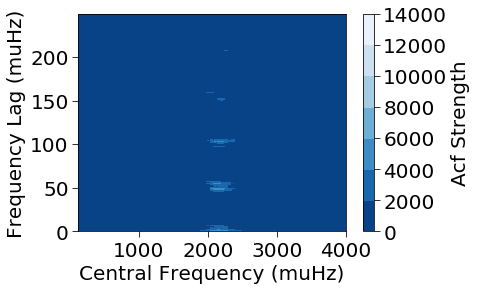

In [36]:
xs = numaxs
ys = np.arange(int(250./fs)) * fs
X, Y = np.meshgrid(xs, ys)
plt.contourf(X, Y, acf.T, cmap='Blues_r')
plt.xlabel('Central Frequency (muHz)')
plt.ylabel('Frequency Lag (muHz)')
plt.colorbar(label='Acf Strength')
plt.xlim(125, 4000)

In [37]:
acf.shape

(8246, 650)

Now let's calculated the MCC (Kiefer 2013)

In [51]:
mcc = np.ones_like(numaxs)
for idx, numax in enumerate(numaxs):
    mcc[idx] = (np.sum(np.abs(acf[idx])) - 1) / len(acf[idx])

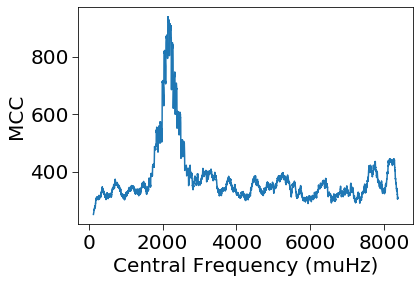

numax is 2141.0


In [53]:
plt.plot(numaxs, mcc)
plt.xlabel('Central Frequency (muHz)')
plt.ylabel('MCC')
plt.show()
print('numax is {}'.format(numaxs[np.argmax(mcc)]))

dnu is 103.37521515299613


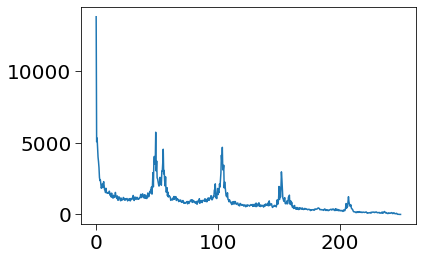

In [60]:
plt.plot(ys, autocorrelate(2141.))
print('dnu is {}'.format(ys[ys>80][np.argmax(autocorrelate(2141.)[ys>80])]))